**👨‍💻 Author:** Hawon Lee  
**🏛️ Affiliation:** Korea University  
**📅 Date:** May 28, 2025  
**📧 Contact:** hw7825@korea.ac.kr  

---

README를 읽고 환경 설정을 완료했다고 가정합니다.  
관련 링크  
🔗 PDB | https://rcsb.org  
🔗 Alphafold Database | https://alphafold.ebi.ac.uk/  
🔗 Biopython parser documentation | https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ

### 🟠 구조 데이터(structure data)란?
- 분자의 구조를 나타내는 파일 형식  
- pdb, sdf, mol2, mmcif 등등 다양한 포맷이 존재
- 포맷마다 양식이 조금씩 다르지만 핵심은 원자마다 x, y, z 좌표 형태로 나타내는 것
- 단백질의 구조는 매우 복잡 --> 주로 pdb (legacy) 파일이나 PDBx/mmCIF (fancy) 파일로 저장됨

### 🟠 단백질 구조 파일 (PDBx/mmCIF) 이해하기
왜 PDXc/mmcif 가 단백질 구조 표현의 새 표준이 되었을까?  
- legacy pdb 포맷은 저장할 수 있는 원자의 갯수 제한이 있음(고정 열 기반) 이와 상관없이 활용되는 mmcif 포맷이 권장됨
- 최근 deposit되는 구조들의 경우에는 mmcif로만 제공되는 경우도 있음.

### 🟠 RCSB API를 이용해서 데이터 검색 및 다운로드
- 크게 원하는 조건의 데이터 엔트리를 검색하는 search API와, 특정 엔트리에 대한 정보를 가져오는 data API로 구분
- 🔗 Search API query builder | https://www.rcsb.org/search/advanced

In [90]:
# Search API
import requests
import json

built_query = ''
built_query = json.loads(built_query) # query를 rcsb에서 복사해서 가져올 때는 따옴표(') 로 감싸서 string으로 만든 다음 json.loads() 함수 활용해서 parsing

def search_rcsb(query):
    response = requests.post(
        "https://search.rcsb.org/rcsbsearch/v2/query",
        json=query,
        headers={"Content-Type": "application/json"}
    )
    response.raise_for_status()
    return response.json()

response = search_rcsb(query=built_query)
response

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [93]:
# Data API

pdb_id = "2hbs"

# 1. MMCIF contents를 string으로써 변수에 저장하고 싶다면: url requests
def get_response(url, r_type='json'):
    response = requests.get(url)
    if response.status_code == 200:
        if r_type=='json':
            result = response.json()
        elif r_type=='text':
            result = response.text
    else:
        raise ConnectionError(f"Error: {response.status_code} while treating query {url}")
    return result

url = f"https://files.rcsb.org/view/{pdb_id}.cif"
mmcif_string = get_response(url, r_type="text")

# 2. MMCIF contents를 file로써 특정 위치에 저장하고 싶다면: Biopython 활용 (또는 위 string 직접 저장)
from Bio.PDB import *
pdbl = PDBList(server='ftp://ftp.pdbj.org') # PDBj 서버 (EBI 서버: ftp://ftp.ebi.ac.uk)
pdbl.retrieve_pdb_file(pdb_id, pdir='./mmcifs', file_format='mmCif')

'./mmcifs/2hbs.cif'

In [94]:
print(mmcif_string)

data_2HBS
# 
_entry.id   2HBS 
# 
_audit_conform.dict_name       mmcif_pdbx.dic 
_audit_conform.dict_version    5.387 
_audit_conform.dict_location   http://mmcif.pdb.org/dictionaries/ascii/mmcif_pdbx.dic 
# 
loop_
_database_2.database_id 
_database_2.database_code 
_database_2.pdbx_database_accession 
_database_2.pdbx_DOI 
PDB   2HBS         pdb_00002hbs 10.2210/pdb2hbs/pdb 
WWPDB D_1000178173 ?            ?                   
# 
loop_
_pdbx_audit_revision_history.ordinal 
_pdbx_audit_revision_history.data_content_type 
_pdbx_audit_revision_history.major_revision 
_pdbx_audit_revision_history.minor_revision 
_pdbx_audit_revision_history.revision_date 
1 'Structure model' 1 0 1997-07-23 
2 'Structure model' 1 1 2008-03-24 
3 'Structure model' 1 2 2011-07-13 
4 'Structure model' 1 3 2017-02-01 
5 'Structure model' 1 4 2024-02-14 
# 
_pdbx_audit_revision_details.ordinal             1 
_pdbx_audit_revision_details.revision_ordinal    1 
_pdbx_audit_revision_details.data_content_type   'St

### 🟠 PDBx/mmCIF 살펴보기
규칙
- 항상 첫 줄은 data_PDB_ID
- \# 으로 시작하는 줄은 주석 -> 기계가 읽지 않음
- 기록할 데이터 항목을 키-밸류 쌍으로 표현
    - data category: 같은 대상에 대한 데이터 아이템을 그룹화 (_atom_site 등)
    - data item: 데이터 카테고리 내의 개별 필드 -> 하나의 값을 가짐  
    `_category.item_name  value`
- 반복되는 데이터를 표현하고자 하는 경우 이들을 loop_로 묶어서 반복 표현


    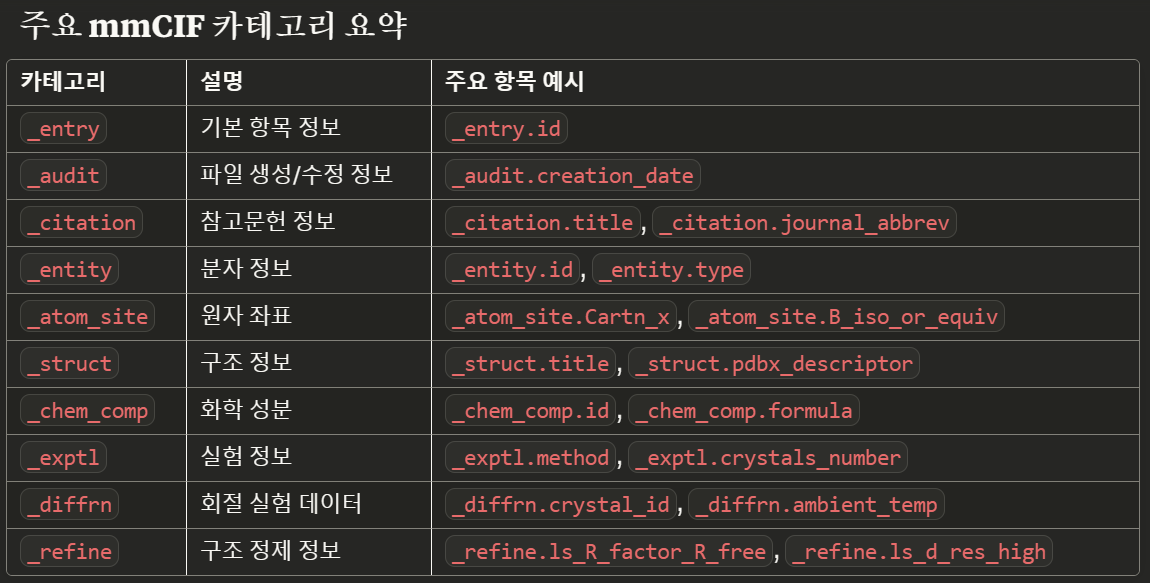

### 🟠 PDBx/mmCIF 살펴보기

**Biopython mmcif parser 사용법**
1. Metadata parsing - `Bio.PDB.MMCIFDict.MMCIFDict`

2. Structure parsing - `Bio.PDB.MMCIFParser`
    - 기본적으로 SMCRA hierarchy을 사용
        - Structure
        - Model
        - Chain
        - Residue
        - Atom

In [95]:
# 1. Metadata parsing
from Bio.PDB.MMCIF2Dict import MMCIF2Dict

mmcif_dict = MMCIF2Dict(f"./mmcifs/{pdb_id}.cif")

print(f"파싱된 mmcif dictionary key들: {mmcif_dict.keys()}\n")

print(mmcif_dict.get("_entity_poly.entity_id")) # 몇개의 unique polymer entity가 존재하는지
print(mmcif_dict.get("_entity_poly.pdbx_seq_one_letter_code_can")) # protein의 canonical sequence
print(mmcif_dict.get("_entity_poly.pdbx_strand_id")) # protein의 canonical sequence

파싱된 mmcif dictionary key들: dict_keys(['data_', '_entry.id', '_audit_conform.dict_name', '_audit_conform.dict_version', '_audit_conform.dict_location', '_database_2.database_id', '_database_2.database_code', '_database_2.pdbx_database_accession', '_database_2.pdbx_DOI', '_pdbx_audit_revision_history.ordinal', '_pdbx_audit_revision_history.data_content_type', '_pdbx_audit_revision_history.major_revision', '_pdbx_audit_revision_history.minor_revision', '_pdbx_audit_revision_history.revision_date', '_pdbx_audit_revision_details.ordinal', '_pdbx_audit_revision_details.revision_ordinal', '_pdbx_audit_revision_details.data_content_type', '_pdbx_audit_revision_details.provider', '_pdbx_audit_revision_details.type', '_pdbx_audit_revision_details.description', '_pdbx_audit_revision_details.details', '_pdbx_audit_revision_group.ordinal', '_pdbx_audit_revision_group.revision_ordinal', '_pdbx_audit_revision_group.data_content_type', '_pdbx_audit_revision_group.group', '_pdbx_audit_revision_category

In [96]:
# 2. Structure parsing
from Bio.PDB import MMCIFParser

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("tutorial", f"./mmcifs/{pdb_id}.cif") # 구조 파싱의 가장 핵심 과정 - structure 객체를 만드는 것

print(f"구조 ID: {structure.id}")
print(f"모델 수: {len(structure)}") # X-ray 구조는 대부분 1개. NMR 구조의 경우 모델의 수가 2개 이상인 경우가 많음.

구조 ID: tutorial
모델 수: 1


In [97]:
# Structure 탐색하기 - SMCRA scheme
for model in structure:
    # print(f"\n모델 ID: {model.id}")
    for chain in model:
        # print(f"\n체인 ID: {chain.id}")
        for residue in chain:
            # print(f"\n잔기 정보: {residue.resname} {residue.id[1]} {residue.segid}")
            for atom in residue:
                # print(f"원자 정보: {atom.name} {atom.element} {atom.coord}")
                pass

In [98]:
# get_ method 를 활용하면 for 문 없이 원하는 객체 가져올 수 있음

atoms = [atom for atom in structure.get_atoms()]
atom = atoms[0]
print("Atom List:", atoms)

print(atom.coord) # atom 좌표 접근
print(atom.id) # atom 원자 이름

Atom List: [<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG1>, <Atom CG2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD1>, <Atom CD2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom OG>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom OD1>, <Atom OD2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>, <Atom CE>, <Atom NZ>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom OG1>, <Atom CG2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom OD1>, <Atom ND2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG1>, <Atom CG2>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>, <Atom CE>, <Atom NZ>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom N>, <Ato

In [99]:
# get_parent 를 활용하여 상위 구성요소로 이동 가능

res = atom.get_parent()

print(res.id) # (hetflag, resseq, icode) | hetflag는 non-polymer인지 아닌지를 표시, resseq은 residue sequence, icode는 insertion 여부 표시
print(res.resname) # amino acid name (3-letter code)

print(res.get_list()) # 해당 residue에 속하는 원자 리스트

(' ', 1, ' ')
VAL
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG1>, <Atom CG2>]


In [100]:
# chain

chain = res.get_parent()

print(chain.id)
print(chain.get_list()) # 해당 chain에 속하는 resiude 리스트

A
[<Residue VAL het=  resseq=1 icode= >, <Residue LEU het=  resseq=2 icode= >, <Residue SER het=  resseq=3 icode= >, <Residue PRO het=  resseq=4 icode= >, <Residue ALA het=  resseq=5 icode= >, <Residue ASP het=  resseq=6 icode= >, <Residue LYS het=  resseq=7 icode= >, <Residue THR het=  resseq=8 icode= >, <Residue ASN het=  resseq=9 icode= >, <Residue VAL het=  resseq=10 icode= >, <Residue LYS het=  resseq=11 icode= >, <Residue ALA het=  resseq=12 icode= >, <Residue ALA het=  resseq=13 icode= >, <Residue TRP het=  resseq=14 icode= >, <Residue GLY het=  resseq=15 icode= >, <Residue LYS het=  resseq=16 icode= >, <Residue VAL het=  resseq=17 icode= >, <Residue GLY het=  resseq=18 icode= >, <Residue ALA het=  resseq=19 icode= >, <Residue HIS het=  resseq=20 icode= >, <Residue ALA het=  resseq=21 icode= >, <Residue GLY het=  resseq=22 icode= >, <Residue GLU het=  resseq=23 icode= >, <Residue TYR het=  resseq=24 icode= >, <Residue GLY het=  resseq=25 icode= >, <Residue ALA het=  resseq=26 ic

### 🟠 그 외 권장되는 mmcif parser들
- `pip install pdbecif`
- `pip install gemmi`
- `pip install mmcif` (wwPDB 공식 파서)

감사합니다.